In [17]:
%load_ext autoreload
%autoreload 2
from trade.datamanager import (
    BaseDataManager,
    DividendDataManager,
    OptionSpotDataManager,
    ForwardDataManager,
    SpotDataManager,
    RatesDataManager,
    Result,
    SpotResult,
    OptionSpotResult,
    DividendsResult,
    ForwardResult,
    RatesResult,
    CacheSpec
)
from trade.datamanager._enums import (
    SeriesId
)
from trade.datamanager.vars import TS
import pandas as pd
from typing import List, Dict, Any, Optional, Union, Tuple
import numpy as np
from dataclasses   import dataclass
from trade.optionlib.vol.implied_vol import (
    vector_vol_estimation,
    bsm_vol_est_brute_force,
    estimate_crr_implied_volatility,
    crr_binomial_pricing,
    bsm_vol_est_minimization,
)
from trade.optionlib.pricing.binomial import vector_crr_binomial_pricing
from trade.optionlib.utils.batch_operation import vector_batch_processor
from trade.datamanager.utils.date import time_distance_helper
from trade.optionlib.config.types import DivType
from trade.helpers.helper import to_datetime
from trade.optionlib.assets.dividend import vector_convert_to_time_frac
from trade.optionlib.utils.format import assert_equal_length, convert_to_array
from trade.datamanager.utils.date import DateRangePacket

from typing import ClassVar
from trade.datamanager.config import OptionDataConfig
from trade.datamanager._enums import SeriesId
from datetime import datetime
from dbase.DataAPI.ThetaData import list_contracts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
c = list_contracts("COST", "2026-01-16")
c.head(50)

,root,expiration,strike,right
0,COST,20260116,265.0,P
1,COST,20260116,265.0,C
2,COST,20260116,275.0,C
3,COST,20260116,275.0,P
4,COST,20260116,285.0,C
5,COST,20260116,285.0,P
6,COST,20260116,295.0,C
7,COST,20260116,295.0,P
8,COST,20260116,305.0,P
9,COST,20260116,305.0,C


In [2]:
@dataclass
class VolatilityResult(Result):
    """Contains volatility surface data."""

    timeseries: Optional[pd.Series] = None
    key: Optional[str] = None

    def is_empty(self) -> bool:
        """Checks if volatility data is missing or empty."""
        return self.timeseries is None or self.timeseries.empty

    def _additional_repr_fields(self) -> Dict[str, Any]:
        """Provides volatility-specific fields for string representation."""
        return {
            "key": self.key,
            "is_empty": self.is_empty(),
        }

    def __repr__(self) -> str:
        return super().__repr__()


In [13]:
@dataclass
class ModelResultPack(Result):
    """
    A container for various model result types.
    """
    ## Main Results
    spot: SpotResult = None
    forward: ForwardResult = None
    dividend: DividendsResult = None
    rates: RatesResult = None
    option_spot: OptionSpotResult = None
    vol: VolatilityResult = None

    ## Guiding Enums
    series_id: SeriesId = None
    dividend_type: DivType = None
    undo_adjust: bool = True

In [10]:
@dataclass
class LoadRequest:
    symbol: str
    start_date: Union[str, pd.Timestamp]
    end_date: Union[str, pd.Timestamp]
    expiration: Union[str, pd.Timestamp]
    strike: Optional[float] = None
    right: Optional[str] = None
    series_id: Optional[SeriesId] = None
    div_type: Optional[DivType] = None
    load_spot: bool = True
    load_forward: bool = True
    load_dividend: bool = True
    load_rates: bool = True
    load_option_spot: bool = False
    undo_adjust: bool = True

    def __post_init__(self):
        if self.load_option_spot:
            if self.strike is None or self.right is None:
                raise ValueError("Strike and right must be provided when loading option spot data.")

In [12]:
def assert_synchronized_model(
    packet: ModelResultPack
) -> None:
    """
    This function runs a comprehensive checks on every model inputs/data to ensure they are streamlined.

    Eg: 
    1. If using discrete dividends, ensure all results that have dividend_type set to discrete. Same for continuous.
    2. If using undo_adjust, ensure all results have undo_adjust set to True.
    3. Ensure all results have the same date ranges where applicable. Or at least the same date range with option spot
    """

    ## 1. Dividend Type Consistency Check
    div_types = set()
    for result in [packet.spot, packet.forward, packet.dividend, packet.option_spot]:
        div = getattr(result, "dividend_type", None)
        if div is not None:
            div_types.add(div)
    if len(div_types) > 1:
        raise ValueError(f"Inconsistent dividend types across model results: {div_types}")
    
    ## 2. Undo Adjust Consistency Check
    undo_adjust_flags = set()
    for result in [packet.spot, packet.forward, packet.dividend, packet.option_spot]:
        ua = getattr(result, "undo_adjust", None)
        if ua is not None:
            undo_adjust_flags.add(ua)
    if len(undo_adjust_flags) > 1:
        raise ValueError(f"Inconsistent undo_adjust flags across model results: {undo_adjust_flags}")
    

In [14]:
def _load_model_data_timeseries(
    load_request: LoadRequest
) -> ModelResultPack:
    """
    Loads model data based on the provided load request.

    Parameters:
        load_request (LoadRequest): The request specifying what data to load.

    Returns:
        ModelResultPack: A container with the loaded model data.
    """
    packet = DateRangePacket(
        start_date=load_request.start_date,
        end_date=load_request.end_date,
        maturity_date=load_request.expiration
    )
    symbol = load_request.symbol
    start_date = packet.start_date
    end_date = packet.end_date
    expiration = packet.maturity_date
    d = load_request.load_dividend
    r = load_request.load_rates
    s = load_request.load_spot
    f = load_request.load_forward
    div_type = load_request.div_type or OptionDataConfig().dividend_type
    D, R, S, F = None, None, None, None

    model_data = ModelResultPack()

    # Load BSM-specific data
    if d:
        D = DividendDataManager(symbol).get_schedule_timeseries(
            start_date=start_date,
            end_date=end_date,
            maturity_date=expiration,
            div_type=div_type,
            undo_adjust=load_request.undo_adjust
        )
    if r:
        R = RatesDataManager().get_risk_free_rate_timeseries(
            start_date=start_date,
            end_date=end_date
        )
    if s:
        S = SpotDataManager(symbol=symbol).get_spot_timeseries(start_date=start_date,
                                                               end_date=end_date,
                                                               undo_adjust=load_request.undo_adjust)
    
    if f:
        F = ForwardDataManager(symbol=symbol).get_forward_timeseries(
            start_date=start_date,
            end_date=end_date,
            dividend_result=D,
            maturity_date=expiration,
            use_chain_spot=load_request.undo_adjust
        )
    
    model_data.dividend = D
    model_data.dividend_type = div_type
    model_data.forward = F
    model_data.rates = R
    model_data.spot = S
    model_data.series_id = SeriesId.HIST
    model_data.undo_adjust = load_request.undo_adjust

    return model_data

        


In [20]:
ts_start = "2025-01-01"
ts_end = "2026-01-18"
expiration = "20260116"
_right = "p"
req = LoadRequest(
    symbol = "COST",
    start_date=ts_start,
    end_date=ts_end,
    expiration=expiration
)

model_data = _load_model_data_timeseries(req)
model_data.forward

2026-01-19 21:21:10 [test] trade.optionlib.assets.dividend INFO: Using dual projection method for ticker COST
2026-01-19 21:21:10 [test] trade.optionlib.assets.dividend INFO: Expected Dividend Size before adjustment: 13, for original valuation: 5. Size from historical divs: 12
2026-01-19 21:21:10 [test] trade.optionlib.assets.dividend INFO: Expected Dividend Size to be projected: 1
2026-01-19 21:21:10 [test] trade.optionlib.assets.dividend INFO: Projected Dividend List: [1.3]
2026-01-19 21:21:10 [test] trade.optionlib.assets.dividend INFO: Combined Dividend List: [0.9, 1.02, 1.02, 1.02, 1.02, 1.16, 1.16, 1.16, 1.16, 1.3, 1.3, 1.3, 1.3]
2026-01-19 21:21:10 [test] trade.optionlib.assets.dividend INFO: Combined Date List: [datetime.date(2023, 2, 2), datetime.date(2023, 5, 4), datetime.date(2023, 8, 24), datetime.date(2023, 11, 2), datetime.date(2024, 2, 1), datetime.date(2024, 4, 25), datetime.date(2024, 7, 26), datetime.date(2024, 11, 1), datetime.date(2025, 2, 7), datetime.date(2025, 5,

ForwardResult(is_empty=False, undo_adjust=True, dividend_type=<DivType.DISCRETE: 'discrete'>, key='symbol:COST|interval:eod|artifact_type:forward|series_id:hist|div_type:DISCRETE|maturity:2026-01-16|use_chain_spot:1')

In [9]:
assert_synchronized_model(model_data)

In [20]:
def vector_crr_iv_estimation(
    S: List[float],
    K: List[float],
    T: List[float],
    r: List[float],
    market_price: List[float],
    dividends: List[Any],
    option_type: List[str],
    N: List[int] = None,
    dividend_type: List[str] = None,
    american: List[bool] = None,
) -> List[float]:
    """Vectorized CRR implied volatility estimation."""

    if not american:
        american = [True] * len(S)

    if not dividend_type:
        dividend_type = ["discrete"] * len(S)

    if not N:
        N = [100] * len(S)

    assert_equal_length(
        S,
        K,
        T,
        r,
        market_price,
        dividends,
        option_type,
        N,
        dividend_type,
        american,
        names=[
            "S",
            "K",
            "T",
            "r",
            "market_price",
            "dividends",
            "option_type",
            "N",
            "dividend_type",
            "american",
        ],
    )
    if len(S) < 200:
        print("Using non-batch processor for CRR implied volatility estimation.")
        return vector_vol_estimation(
            estimate_crr_implied_volatility,
            S,
            K,
            T,
            r,
            market_price,
            dividends,
            option_type,
            N,
            dividend_type,
            [True] * len(dividends),
        )

    return vector_batch_processor(
        vector_vol_estimation,
        estimate_crr_implied_volatility,
        S,
        K,
        T,
        r,
        market_price,
        dividends,
        option_type,
        N,
        dividend_type,
        [True] * len(dividends),
    )


In [14]:
def vector_bsm_iv_estimation(
    F: List[float],
    K: List[float],
    T: List[float],
    r: List[float],
    market_price: List[float],
    right: List[str],
) -> List[float]:
    """Vectorized BSM implied volatility estimation."""

    assert_equal_length(
        F,
        K,
        T,
        r,
        market_price,
        right,
        names=[
            "F",
            "K",
            "T",
            "r",
            "market_price",
            "right",
        ],
    )

    return vector_vol_estimation(bsm_vol_est_brute_force, F, K, T, r, market_price, right)


In [ ]:

market_price = (
    OptionSpotDataManager(symbol="AAPL")
    .get_option_spot_timeseries(
        start_date=ts_start,
        end_date=ts_end,
        strike=200,
        expiration=expiration,
        right=_right,
    )
    .midpoint
)
dividends = DividendDataManager(symbol="AAPL").get_schedule_timeseries(
    start_date=market_price.index.min(),
    end_date=market_price.index.max(),
    maturity_date=expiration,
    div_type=DivType.DISCRETE,
)
dividends_res = vector_convert_to_time_frac(
    schedules=dividends.daily_discrete_dividends,
    valuation_dates=dividends.daily_discrete_dividends.index.tolist(),
    end_dates=[to_datetime(expiration)] * len(dividends.daily_discrete_dividends),
)

sigma = [0.2] * len(dividends_res)
r = (
    RatesDataManager()
    .get_risk_free_rate_timeseries(
        start_date=market_price.index.min(),
        end_date=market_price.index.max(),
    )
    .daily_risk_free_rates
)
T = [time_distance_helper(start=dt, end=expiration) for dt in dividends.daily_discrete_dividends.index]
S0 = (
    SpotDataManager(symbol="AAPL")
    .get_spot_timeseries(
        start_date=market_price.index.min(),
        end_date=market_price.index.max(),
    )
    .daily_spot
)

F = (
    ForwardDataManager("AAPL")
    .get_forward_timeseries(
        start_date=market_price.index.min(),
        end_date=market_price.index.max(),
        maturity_date=expiration,
        div_type=DivType.DISCRETE,
        use_chain_spot=True,
    )
    .daily_discrete_forward
)

right = [_right] * len(dividends.daily_discrete_dividends)
dividend_type = [DivType.DISCRETE.value] * len(dividends.daily_discrete_dividends)
K = [200.0] * len(dividends.daily_discrete_dividends)


['2025-11-20', '2025-11-21', '2025-11-24', '2025-11-25', '2025-11-26', '2025-11-28', '2025-12-01', '2025-12-02', '2025-12-03', '2025-12-04', '2025-12-05', '2025-12-08', '2025-12-09', '2025-12-10', '2025-12-11', '2025-12-12', '2025-12-15', '2025-12-16', '2025-12-17', '2025-12-18', '2025-12-19', '2025-12-22', '2025-12-23', '2025-12-24', '2025-12-26', '2025-12-29', '2025-12-30', '2025-12-31', '2026-01-02', '2026-01-05', '2026-01-06', '2026-01-07', '2026-01-08', '2026-01-09', '2026-01-12', '2026-01-13', '2026-01-14', '2026-01-15', '2026-01-16']
Sanitizing data from 2025-11-20 00:00:00 to 2026-01-16 00:00:00...
Sanitizing data from 2025-11-20 to 2026-01-16...
Sanitizing data from 2025-11-20 00:00:00 to 2026-01-16 00:00:00...
Sanitizing data from 2025-11-20 to 2026-01-16...


In [ ]:


class VolDataManager(BaseDataManager):
    CACHE_NAME: ClassVar[str] = "vol_data_manager_cache"
    DEFAULT_SERIES_ID: ClassVar["SeriesId"] = SeriesId.HIST
    CONFIG = OptionDataConfig()
    INSTANCES = {}

    def __new__(cls, symbol: str, *args: Any, **kwargs: Any) -> "VolDataManager":
        if symbol not in cls.INSTANCES:
            instance = super(VolDataManager, cls).__new__(cls)
            cls.INSTANCES[symbol] = instance
        return cls.INSTANCES[symbol]


    def __init__(
        self, symbol: str, *, cache_spec: Optional[CacheSpec] = None, enable_namespacing: bool = False
    ) -> None:
        
        if getattr(self, "_initialized", False):
            return
        self._initialized = True
        super().__init__(
            symbol,
            cache_spec=cache_spec,
            enable_namespacing=enable_namespacing,
        )

    

    def _get_bsm_implied_volatility_timeseries(
        self,
        start_date: str,
        end_date: str,
        expiration: str,
        strike: float,
        right: str,
        div_type: Optional[DivType] = DivType.DISCRETE,
        *,
        F: Optional[ForwardResult] = None,
        S: Optional[SpotResult] = None,
        r: Optional[RatesResult] = None,
        market_price: Optional[OptionSpotResult] = None,
        undo_adjust: bool = True,

    ) -> VolatilityResult:
        """Retrieves BSM implied volatility timeseries."""
        div_type = div_type or self.CONFIG.dividend_type
        ## Load model data if not provided
        load_request = LoadRequest(
            symbol=self.symbol,
            start_date=start_date,
            end_date=end_date,
            expiration=expiration,
            div_type=div_type,
            load_spot=S is None,
            load_forward=F is None,
            load_rates=r is None,
            
            undo_adjust=undo_adjust,

        )


In [18]:

vector_bsm_iv_estimation(
    F,
    K,
    T,
    r,
    market_price,
    right,
)

[np.float64(0.37056031400785017),
 np.float64(0.3574376109402735),
 np.float64(0.36393647341183527),
 np.float64(0.37518450461261527),
 np.float64(0.36693594839870997),
 np.float64(0.341190454761369),
 np.float64(0.36556118902972573),
 np.float64(0.36743586089652236),
 np.float64(0.37343481087027175),
 np.float64(0.36556118902972573),
 np.float64(0.3554379609490237),
 np.float64(0.35406320158003945),
 np.float64(0.36268669216730415),
 np.float64(0.3676858171454286),
 np.float64(0.3766842421060526),
 np.float64(0.36668599214980374),
 np.float64(0.3623117577939448),
 np.float64(0.35418817970449257),
 np.float64(0.3721850296257406),
 np.float64(0.34718940473511833),
 np.float64(0.35306337658441456),
 np.float64(0.33794102352558814),
 np.float64(0.3401906297657441),
 np.float64(0.3409404985124628),
 np.float64(0.3383159578989475),
 np.float64(0.3450647766194155),
 np.float64(0.3430651266281657),
 np.float64(0.3533133328333208),
 np.float64(0.3393157828945723),
 np.float64(0.347689317232930

In [22]:

v = vector_crr_iv_estimation(
    S0.tolist(),
    K,
    T,
    r.tolist(),
    market_price.tolist(),
    dividends_res,
    right,
    [100] * len(dividends.daily_discrete_dividends),
    dividend_type,
    [True] * len(dividends.daily_discrete_dividends)
)

Using non-batch processor for CRR implied volatility estimation.


<Axes: >

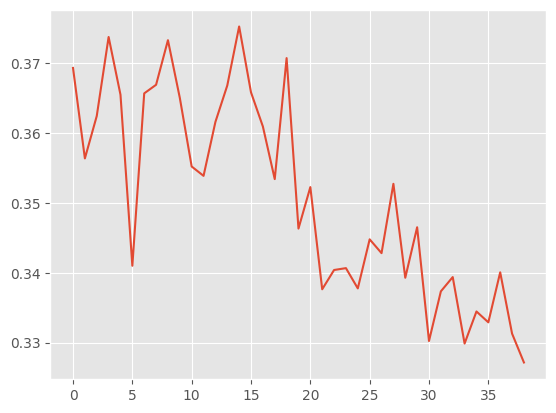

In [9]:
pd.Series(v).plot()
